# 07 Stateful Computation

Original Documentation: https://docs.jax.dev/en/latest/stateful-computations.html


In [1]:
import jax
import jax.numpy as jnp

JAX transformations (`jax.jit()`, `jax.vmap()`, `jax.grad()`) require the functions they wrap to be pure. In ML, state may exist in forms like model parameters, optimizer state, and stateful layers.

## A simple example

Consider a toy example of a `Counter` class:


In [2]:
class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0


c = Counter()
for _ in range(3):
    print(c.count())

1
2
3


`self.n` is the state that is maintained and modified as a side-effect during `count()` calls.

For the sake of example, assume we must JIT compile `count()` to improve performance.


In [3]:
c = Counter()
fast_count = jax.jit(c.count)

for _ in range(3):
    print(fast_count())

1
1
1


Since the side-effect of incrementing `self.n` is only executed once at trace time, subsequent `fast_count()` calls will not repeat the side effect since the XLA compiler will remove them.

## The solution: explicit state


In [4]:
CounterState = int


class Counter:
    """A simple counter."""

    def count(self, n: CounterState) -> int:
        return n + 1

    def reset(self):
        return 0


c = Counter()
state = c.reset()

fast_count = jax.jit(c.count)

for _ in range(3):
    state = fast_count(state)
    print(state)

1
2
3


Allow the user to manage the necessary state so that `count()` can be pure and therefore JIT compiled.

## Simple example

Consider an example of a linear regression via gradient descent. Here, the only state is model parameters:


In [5]:
from typing import NamedTuple

LEARNING_RATE = 0.005


class Params(NamedTuple):
    weights: jnp.ndarray
    biases: jnp.ndarray


def init(rng):
    """Initialize model weights and biases randomly"""
    W_key, b_key = jax.random.split(rng, 2)
    W = jax.random.normal(W_key, ())
    b = jax.random.normal(b_key, ())
    return Params(W, b)


def loss(params, x, y):
    """Compute the MSE of the model's prediction on x against y"""
    preds = params.weights * x + params.biases
    return jnp.mean((preds - y) ** 2)


@jax.jit
def update(params, x, y):
    loss_value, grads = jax.value_and_grad(loss)(params, x, y)

    # Adjust weights by gradient direction amplified by learning rate
    return loss_value, jax.tree.map(lambda param, g: param - g * LEARNING_RATE, params, grads)

Notice that we manually pipe the params in and out of the update function.

We can write a simple train loop to train our regression model:


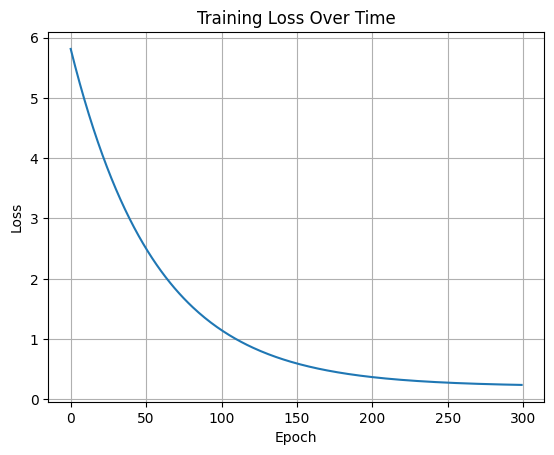

In [10]:
import matplotlib.pyplot as plt

rng = jax.random.key(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
losses = []
for i in range(300):
    loss_value, params = update(params, xs, ys)
    losses.append(loss_value)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()

We’ve successfully trained the model with only pure functions!
